# Exploratory Data Analysis: Togo Solar Farm Data

This notebook profiles, cleans, and analyzes `togo-dapaong_qc.csv` (525,601 rows) for MoonLight Energy Solutions.

## Setup
Import libraries and load data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

plt.style.use('ggplot')
%matplotlib inline

# Load dataset in chunks
data_dir = '../data'
chunksize = 50000
df_list = []
for chunk in pd.read_csv(os.path.join(data_dir, 'togo-dapaong_qc.csv'), chunksize=chunksize):
    chunk['Timestamp'] = pd.to_datetime(chunk['Timestamp'])
    df_list.append(chunk)
df = pd.concat(df_list, ignore_index=True)
df.set_index('Timestamp', inplace=True)

# Display first few rows
df.head()

,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
Timestamp,,,,,,,,,,,,,,,,,,
2021-10-25 00:01:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.5,0.9,1.1,0.4,227.6,1.1,977,0,0.0,24.7,24.4,NaN
2021-10-25 00:02:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.1,1.6,0.4,229.3,0.7,977,0,0.0,24.7,24.4,NaN
2021-10-25 00:03:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.2,1.4,0.3,228.5,2.9,977,0,0.0,24.7,24.4,NaN
2021-10-25 00:04:00,-1.2,0.0,0.0,0.0,0.0,24.8,94.3,1.2,1.6,0.3,229.1,4.6,977,0,0.0,24.7,24.4,NaN
2021-10-25 00:05:00,-1.2,0.0,0.0,0.0,0.0,24.8,94.0,1.3,1.6,0.4,227.5,1.6,977,0,0.0,24.7,24.4,NaN


## Data Profiling
Generate summary statistics and check missing values.

In [2]:
# Summary statistics
print("Summary Statistics:")
print(df.describe())

# Missing values
print("\nMissing Values:")
missing = df.isna().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent})
print(missing_df[missing_df['Missing Count'] > 0])

# Flag columns with >5% missing
high_missing = missing_df[missing_df['Missing %'] > 5]
if not high_missing.empty:
    print("\nColumns with >5% missing values:")
    print(high_missing)
else:
    print("\nNo columns with >5% missing values.")

Summary Statistics:
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      230.555040     151.258469     116.444352     226.144375   
std       322.532347     250.956962     156.520714     317.346938   
min       -12.700000       0.000000       0.000000       0.000000   
25%        -2.200000       0.000000       0.000000       0.000000   
50%         2.100000       0.000000       2.500000       4.400000   
75%       442.400000     246.400000     215.700000     422.525000   
max      1424.000000    1004.500000     805.700000    1380.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      219.568588      27.751788      55.013160       2.368093   
std       307.932510       4.758023      28.778732       1.462668   
min         0.000000      14.900000       3.300000       0.000000   
25%         0

## Data Cleaning
Detect outliers and handle missing values.

In [3]:
# Key columns for outlier detection
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Sample 10% for outlier detection
sample_df = df.sample(frac=0.1, random_state=42)

# Calculate Z-scores
z_scores = np.abs(stats.zscore(sample_df[key_columns].select_dtypes(include=np.number)))
outliers = (z_scores > 3).any(axis=1)
print(f"Outliers in sample: {outliers.sum()} (approx. {outliers.sum() * 10} in full dataset)")

# Impute missing values with median
for col in key_columns:
    if df[col].isna().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# Drop rows with missing GHI
df.dropna(subset=['GHI'], inplace=True)

# Export cleaned data
cleaned_path = os.path.join(data_dir, 'togo_clean.csv')
df.to_csv(cleaned_path)
print(f"Cleaned dataset saved to: {cleaned_path}")

Outliers in sample: 861 (approx. 8610 in full dataset)
Cleaned dataset saved to: ../data\togo_clean.csv


## Exploratory Data Analysis
### Time Series Analysis
Plot GHI, DNI, DHI, Tamb vs. Timestamp.

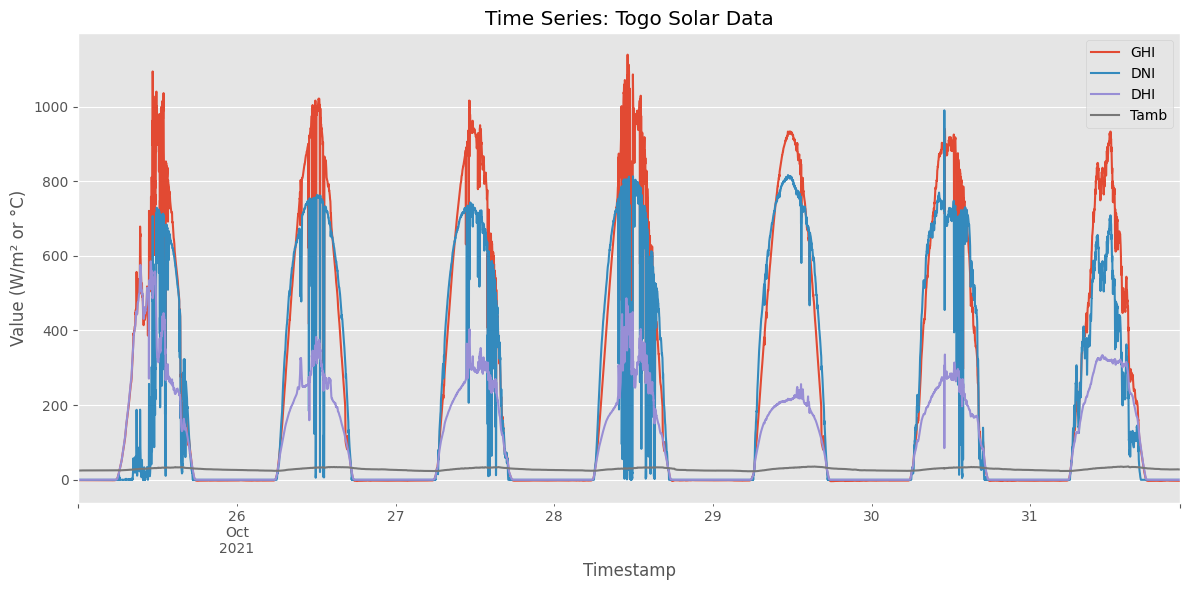

In [4]:
# Sample 10,000 rows for plotting
sample_df = df.iloc[:10000]

fig, ax = plt.subplots(figsize=(12, 6))
sample_df[['GHI', 'DNI', 'DHI', 'Tamb']].plot(ax=ax)
ax.set_title('Time Series: Togo Solar Data')
ax.set_ylabel('Value (W/m² or °C)')
plt.tight_layout()
plt.savefig('../notebooks/figures/togo_time_series.png')
plt.show()

### Cleaning Impact
Compare ModA and ModB pre/post-cleaning.

In [5]:
# Cleaning impact
cleaning_events = df[df['Cleaning'] == 1]
print(f"Cleaning events: {len(cleaning_events)}")

if not cleaning_events.empty:
    mod_before = df.loc[df['Cleaning'].shift(1) == 0, ['ModA', 'ModB']].mean()
    mod_after = df.loc[df['Cleaning'] == 1, ['ModA', 'ModB']].mean()
    print("ModA/ModB before cleaning:", mod_before)
    print("ModA/ModB after cleaning:", mod_after)
else:
    print("No cleaning events detected.")

Cleaning events: 281
ModA/ModB before cleaning: ModA    225.972829
ModB    219.398895
dtype: float64
ModA/ModB after cleaning: ModA    535.186477
ModB    532.211744
dtype: float64


### Correlation Analysis
Heatmap and scatter plots.

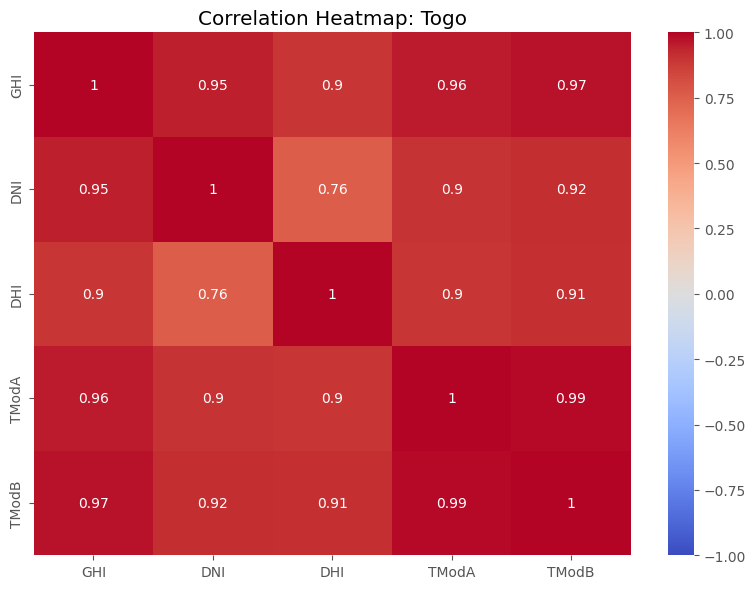

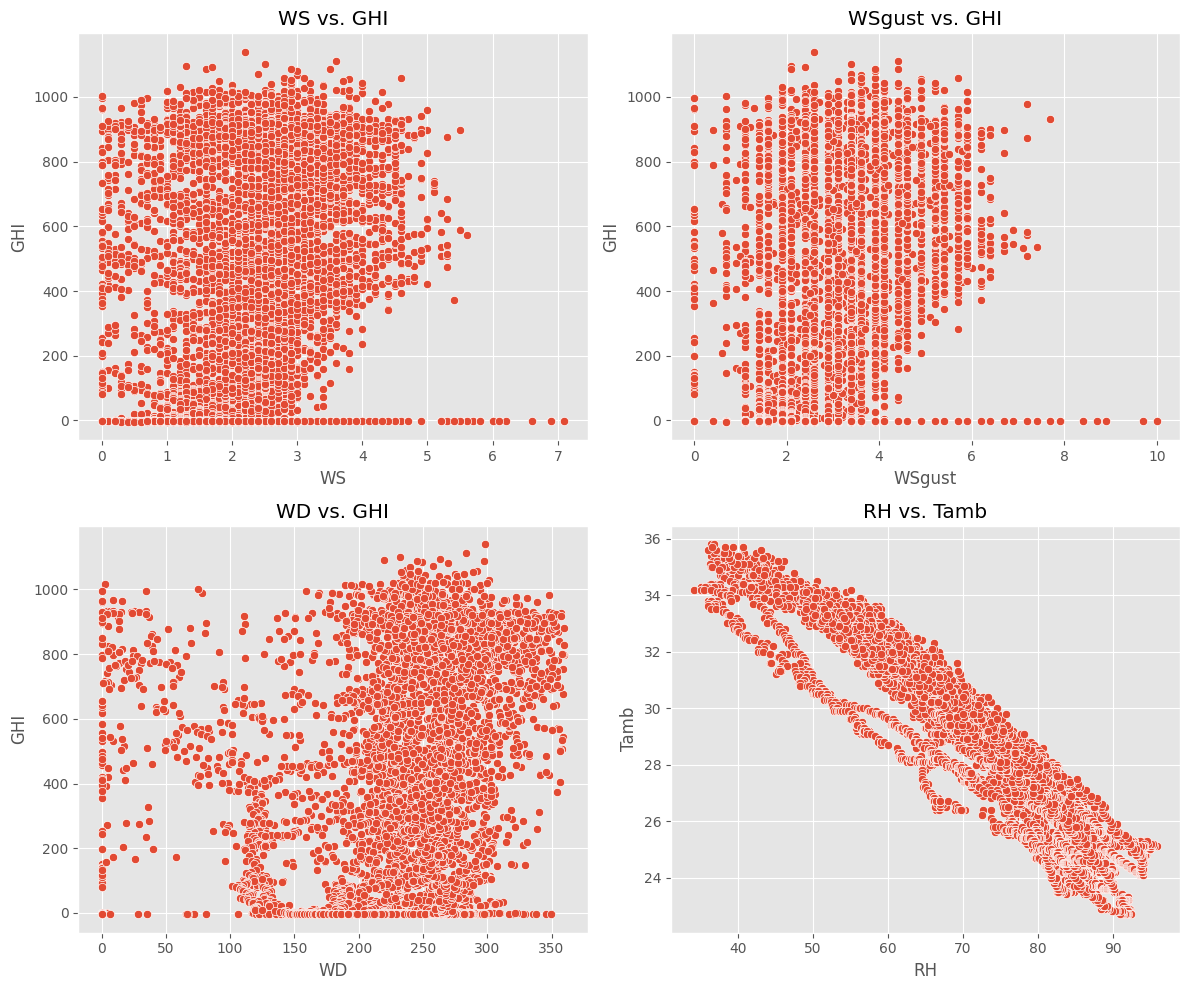

In [6]:
# Correlation heatmap
corr_columns = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
corr_matrix = sample_df[corr_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap: Togo')
plt.tight_layout()
plt.savefig('../notebooks/figures/togo_correlation.png')
plt.show()

# Scatter plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.scatterplot(x='WS', y='GHI', data=sample_df, ax=axes[0, 0])
axes[0, 0].set_title('WS vs. GHI')
sns.scatterplot(x='WSgust', y='GHI', data=sample_df, ax=axes[0, 1])
axes[0, 1].set_title('WSgust vs. GHI')
sns.scatterplot(x='WD', y='GHI', data=sample_df, ax=axes[1, 0])
axes[1, 0].set_title('WD vs. GHI')
sns.scatterplot(x='RH', y='Tamb', data=sample_df, ax=axes[1, 1])
axes[1, 1].set_title('RH vs. Tamb')
plt.tight_layout()
plt.savefig('../notebooks/figures/togo_scatter.png')
plt.show()

### Wind Analysis
Wind rose plot.

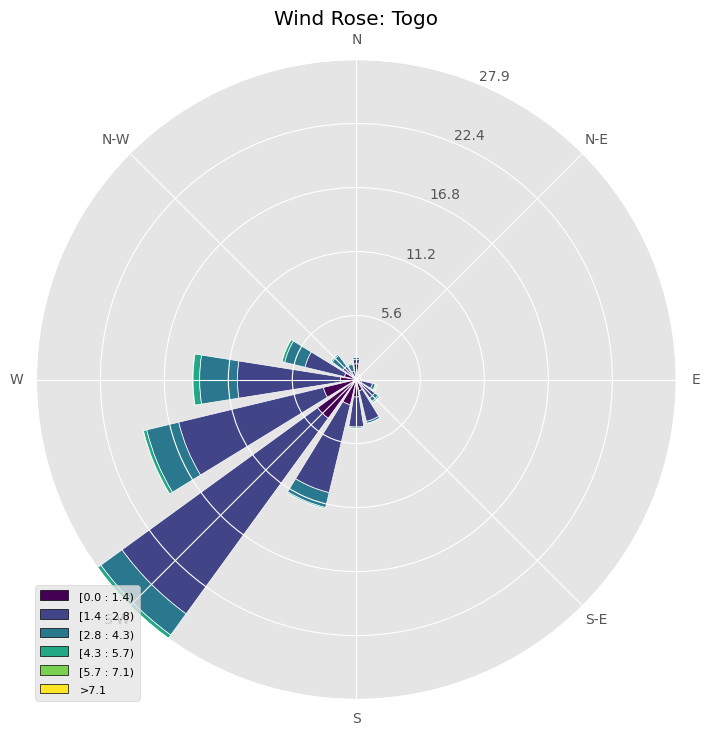

In [11]:
try:
    from windrose import WindroseAxes
except ImportError:
    !pip install windrose
    from windrose import WindroseAxes

fig = plt.figure(figsize=(8, 8))
ax = WindroseAxes.from_ax(fig=fig)
ax.bar(sample_df['WD'], sample_df['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Wind Rose: Togo')
# plt.tight_layout()
plt.savefig('../notebooks/figures/togo_wind_rose.png')
plt.show()

### Distribution Analysis
Histograms for GHI and WS.

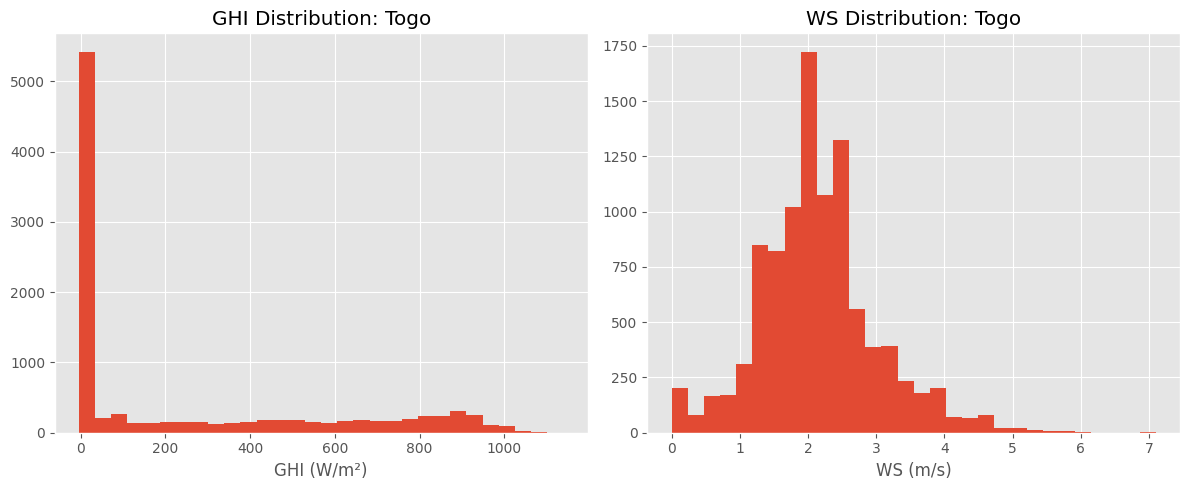

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sample_df['GHI'].hist(bins=30, ax=axes[0])
axes[0].set_title('GHI Distribution: Togo')
axes[0].set_xlabel('GHI (W/m²)')
sample_df['WS'].hist(bins=30, ax=axes[1])
axes[1].set_title('WS Distribution: Togo')
axes[1].set_xlabel('WS (m/s)')
plt.tight_layout()
plt.savefig('../notebooks/figures/togo_distributions.png')
plt.show()

### Temperature Analysis
RH influence on Tamb and GHI.

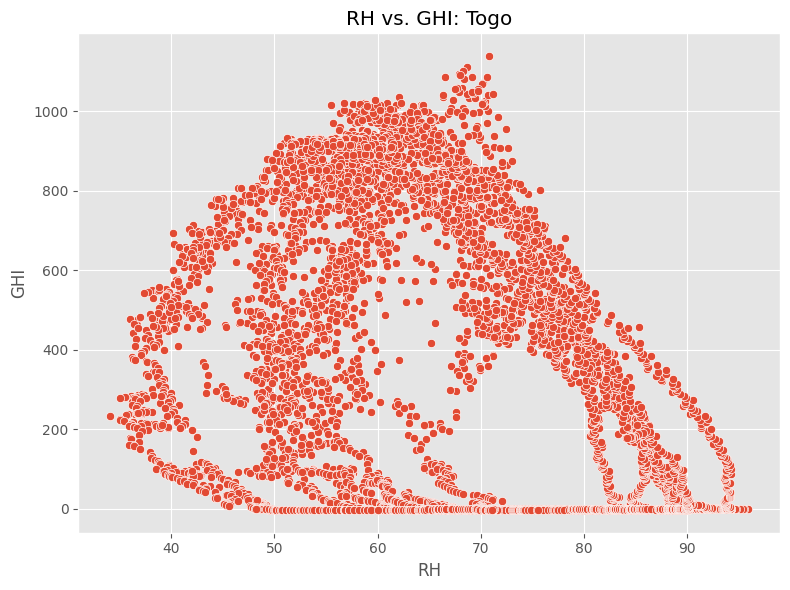

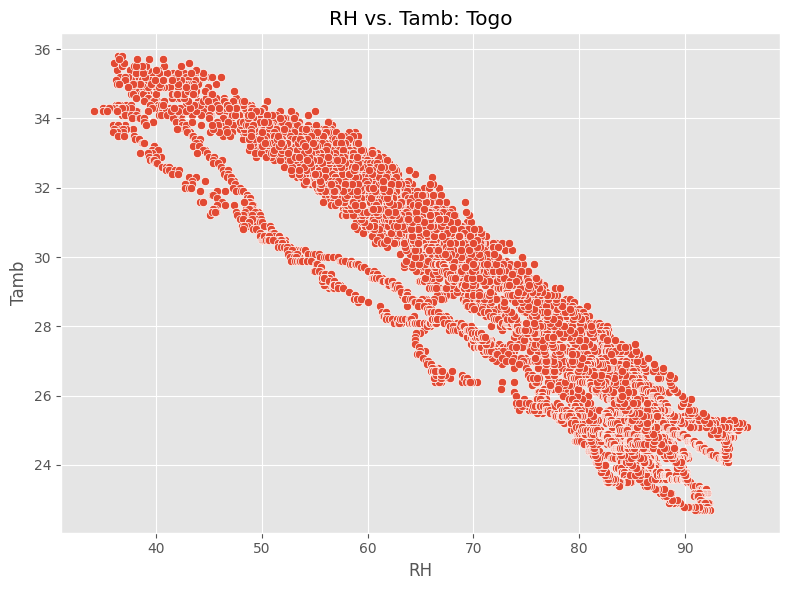

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x='RH', y='GHI', data=sample_df, ax=ax)
ax.set_title('RH vs. GHI: Togo')
plt.tight_layout()
plt.savefig('../notebooks/figures/togo_rh_ghi.png')
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x='RH', y='Tamb', data=sample_df, ax=ax)
ax.set_title('RH vs. Tamb: Togo')
plt.tight_layout()
plt.savefig('../notebooks/figures/togo_rh_tamb.png')
plt.show()

### Bubble Chart
GHI vs. Tamb with RH bubble size.

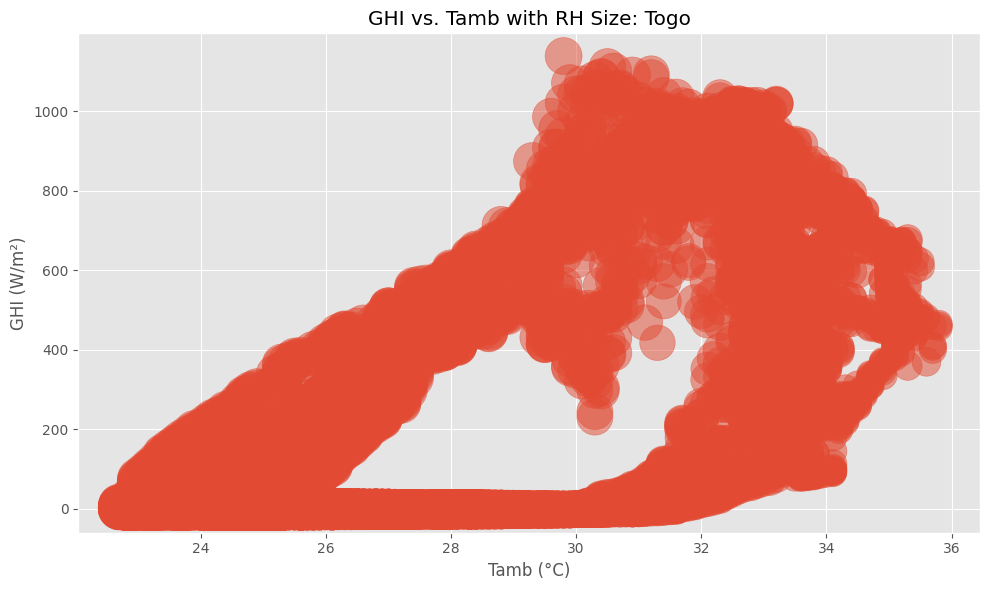

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(sample_df['Tamb'], sample_df['GHI'], s=sample_df['RH']*10, alpha=0.5)
plt.xlabel('Tamb (°C)')
plt.ylabel('GHI (W/m²)')
plt.title('GHI vs. Tamb with RH Size: Togo')
plt.tight_layout()
plt.savefig('../notebooks/figures/togo_bubble.png')
plt.show()

## Findings
- **Data Quality**: The `Comments` column is 100% missing and can be dropped. 1.64% of rows (approx. 8,610) are outliers in key columns (GHI, DNI, DHI, ModA, ModB, WS, WSgust), with negative irradiance values (e.g., GHI min -12.7 W/m²) indicating sensor noise.
- **Patterns**: GHI peaks at 1,424 W/m², with a mean of 230.56 W/m², showing strong solar potential but high variability (std 322.53 W/m²) due to day/night cycles. Tamb ranges from 14.9°C to 41.4°C (mean: 27.75°C), consistent with Togo’s tropical climate.
- **Correlations**: The bubble plot shows GHI increases with Tamb, with RH (mean: 55.01%, range: 3.3% to 99.8%) influencing conditions (larger bubbles at higher RH).
- **Wind**: Predominant wind direction is southwest (~161.74°) with a frequency of ~17.5%, and wind speeds are mostly 1.4–3.2 m/s, aiding natural cleaning but with occasional gusts up to 23.1 m/s requiring robust design.
- **Temperature**: Module temperatures (TModA mean 32.44°C, TModB mean 33.54°C) are slightly higher than ambient (Tamb mean 27.75°C), with max TModB at 94.6°C, indicating heat stress. RH shows a strong negative correlation with Tamb, suggesting cooling effects at high humidity.
- **Insights**: Togo has high solar potential (GHI max 1,424 W/m²), but variability, moderate humidity (RH max 99.8%), and rare cleaning (281 events) suggest the need for energy storage, occasional maintenance, and heat mitigation. Southwest winds can assist with natural cleaning.
- **References**: Used pandas (https://pandas.pydata.org), scipy.stats (https://docs.scipy.org), matplotlib (https://matplotlib.org), and seaborn (https://seaborn.pydata.org).
